# Sequential NLP - Sarcasm Detection

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense,Input, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant
import transformers
import tokenizers

import random
# assert tf.__version__ >= '2.0'
%matplotlib inline

# Set random state
random_state = 7
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Data Extraction, Analysis and Cleaning

In [2]:
data = pd.read_json('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 11 - Sequential NLP\\Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. The first ten rows of the data are as below..')
data.head(10)

Data has 26709 rows and 3 columns. The first ten rows of the data are as below..


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [3]:
# Let us check if there are any null values
print("Null Values:")
print(data.isnull().sum())
print("\nData Shape: " , data.shape)

Null Values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64

Data Shape:  (26709, 3)


----------------------------------------
Value Counts for `is_sarcastic` label
----------------------------------------
Is Sarcastic count: 11724 i.e. 43.9%
Not Sarcastic count: 14985 i.e. 56.1%


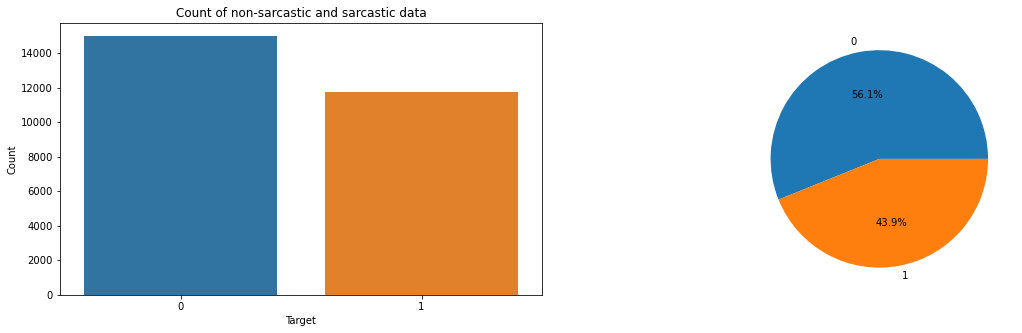

In [4]:
print('--'*20); print('Value Counts for `is_sarcastic` label'); print('--'*20)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 2)}%')
print(f'Not Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 2)}%')

# print(data.is_sarcastic.value_counts() ,"\n")

fig, ax = plt.subplots(1,2, figsize=(19, 5))
f1 = sns.countplot(data.is_sarcastic, ax = ax[0]);
f1.set_title("Count of non-sarcastic and sarcastic data")
f1.set_ylabel("Count")
f1.set_xlabel("Target")

f2 = plt.pie(data["is_sarcastic"].value_counts().values,explode=[0,0],labels=data.is_sarcastic.value_counts().index, autopct='%1.1f%%')
fig.show()

In the above visualization, we examine the distribution of sarcastic and non-sarcastic data. First graph is a countplot from seaborn. It shows both sarcastic and non-sarcastic posts. Second graph is a pie graph. If we use pie graph, we can examine percentages of distributions.

It is seen that data is not highly imbalanced, it is fairly balanced dataset. 56.1 percent of posts are non-sarcastic and 43.9 percent of data are sarcastic.

In [5]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*25)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
--------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,11724
Non-sarcastic,14985,1


By the above table we can observe that all the Sarcastic posts are from 'the onion' and all but 1 post which are non-sarcastic are from 'huffington post'

------------------------------------------------------------
Few random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: seventh-grade class scrambling to piece together teacher's home life from desktop background before powerpoint opened
label: 1

Headline: 'i'd like you to post long, aggressive rants on social media,' says bernie sanders in supporter's interpretation of speech
label: 1

Headline: embarrassed jcpenney announces all it's sold in past year is two fleece jackets and a scattergories game
label: 1

Headline: woman digs excitedly into ingrown hair around bikini line like grave robber pillaging spoils of the dead
label: 1

Headline: russian officials scrambling as plan to delegitimize western democracy moving way faster than intended
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
--------------------

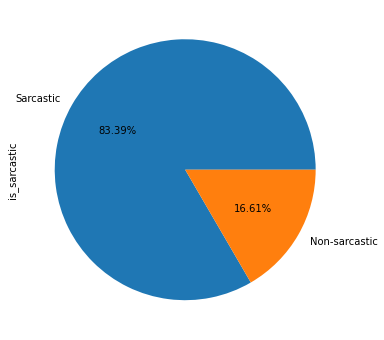

In [6]:
# Lets check few random headlines and labels from the data
print('--'*30); 
print('Few random headlines and labels from the data where the length of headline is > 100'); 
print('--'*30)
# rand = random.sample(range(1, data.shape[0]), 5)
# headlines, labels = list(data.loc[rand, 'headline']), list(data.loc[rand, 'is_sarcastic'])

indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); 
print('Distributon of label where the length of headline is > 100'); 
print('--'*30)

_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.2f%%', 
                                                          labels = ['Sarcastic', 'Non-sarcastic'], 
                                                          figsize = (10, 6))

In [7]:
# Drop unnecessary columns
data.drop('article_link', axis = 1, inplace = True)

## Data Pre-processing

Data pre-processing steps taken before applying model on the data
* Converting to lower case
* Removing multiple spaces between words
* Removing special characters
* Removing punctuations
* Removing stopwords
* Lemmatization to get the root word

In [8]:
stop = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

In [9]:
#Converting headlines to lower case
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

#Removing multiple spaces between words
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

#Removing punctiation marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing special characters
def remove_specialchars(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


#Total function
def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

data['cleaned_headline'] = data['headline'].apply(cleaning)

Let us get the length and number of words of each line, Find the maximum length and number words in posts

In [10]:
# print('--'*50); 
# print('Get the length of each line, find the maximum length and print the maximum length line'); 
# print('--'*50)

# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('')
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

Minimum line length: 0
Maximum line length: 227

Line with maximum length: maya angelou poet author civil right activist holy cow tony award nominated actress college professor magazine editor streetcar conductor really streetcar conductor wow calypso singer nightclub performer foreign journalist dead


In [11]:
# print('--'*40); 
# print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
# print('--'*40)

# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('')
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

Minimum number of words: 1
Maximum number of words: 30

Line with maximum number of words: maya angelou poet author civil right activist holy cow tony award nominated actress college professor magazine editor streetcar conductor really streetcar conductor wow calypso singer nightclub performer foreign journalist dead


In [12]:
# print('Word Cloud of Sarcastic and Non-sarcastic headlines')
data['headline'] = data['headline'].fillna('')

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

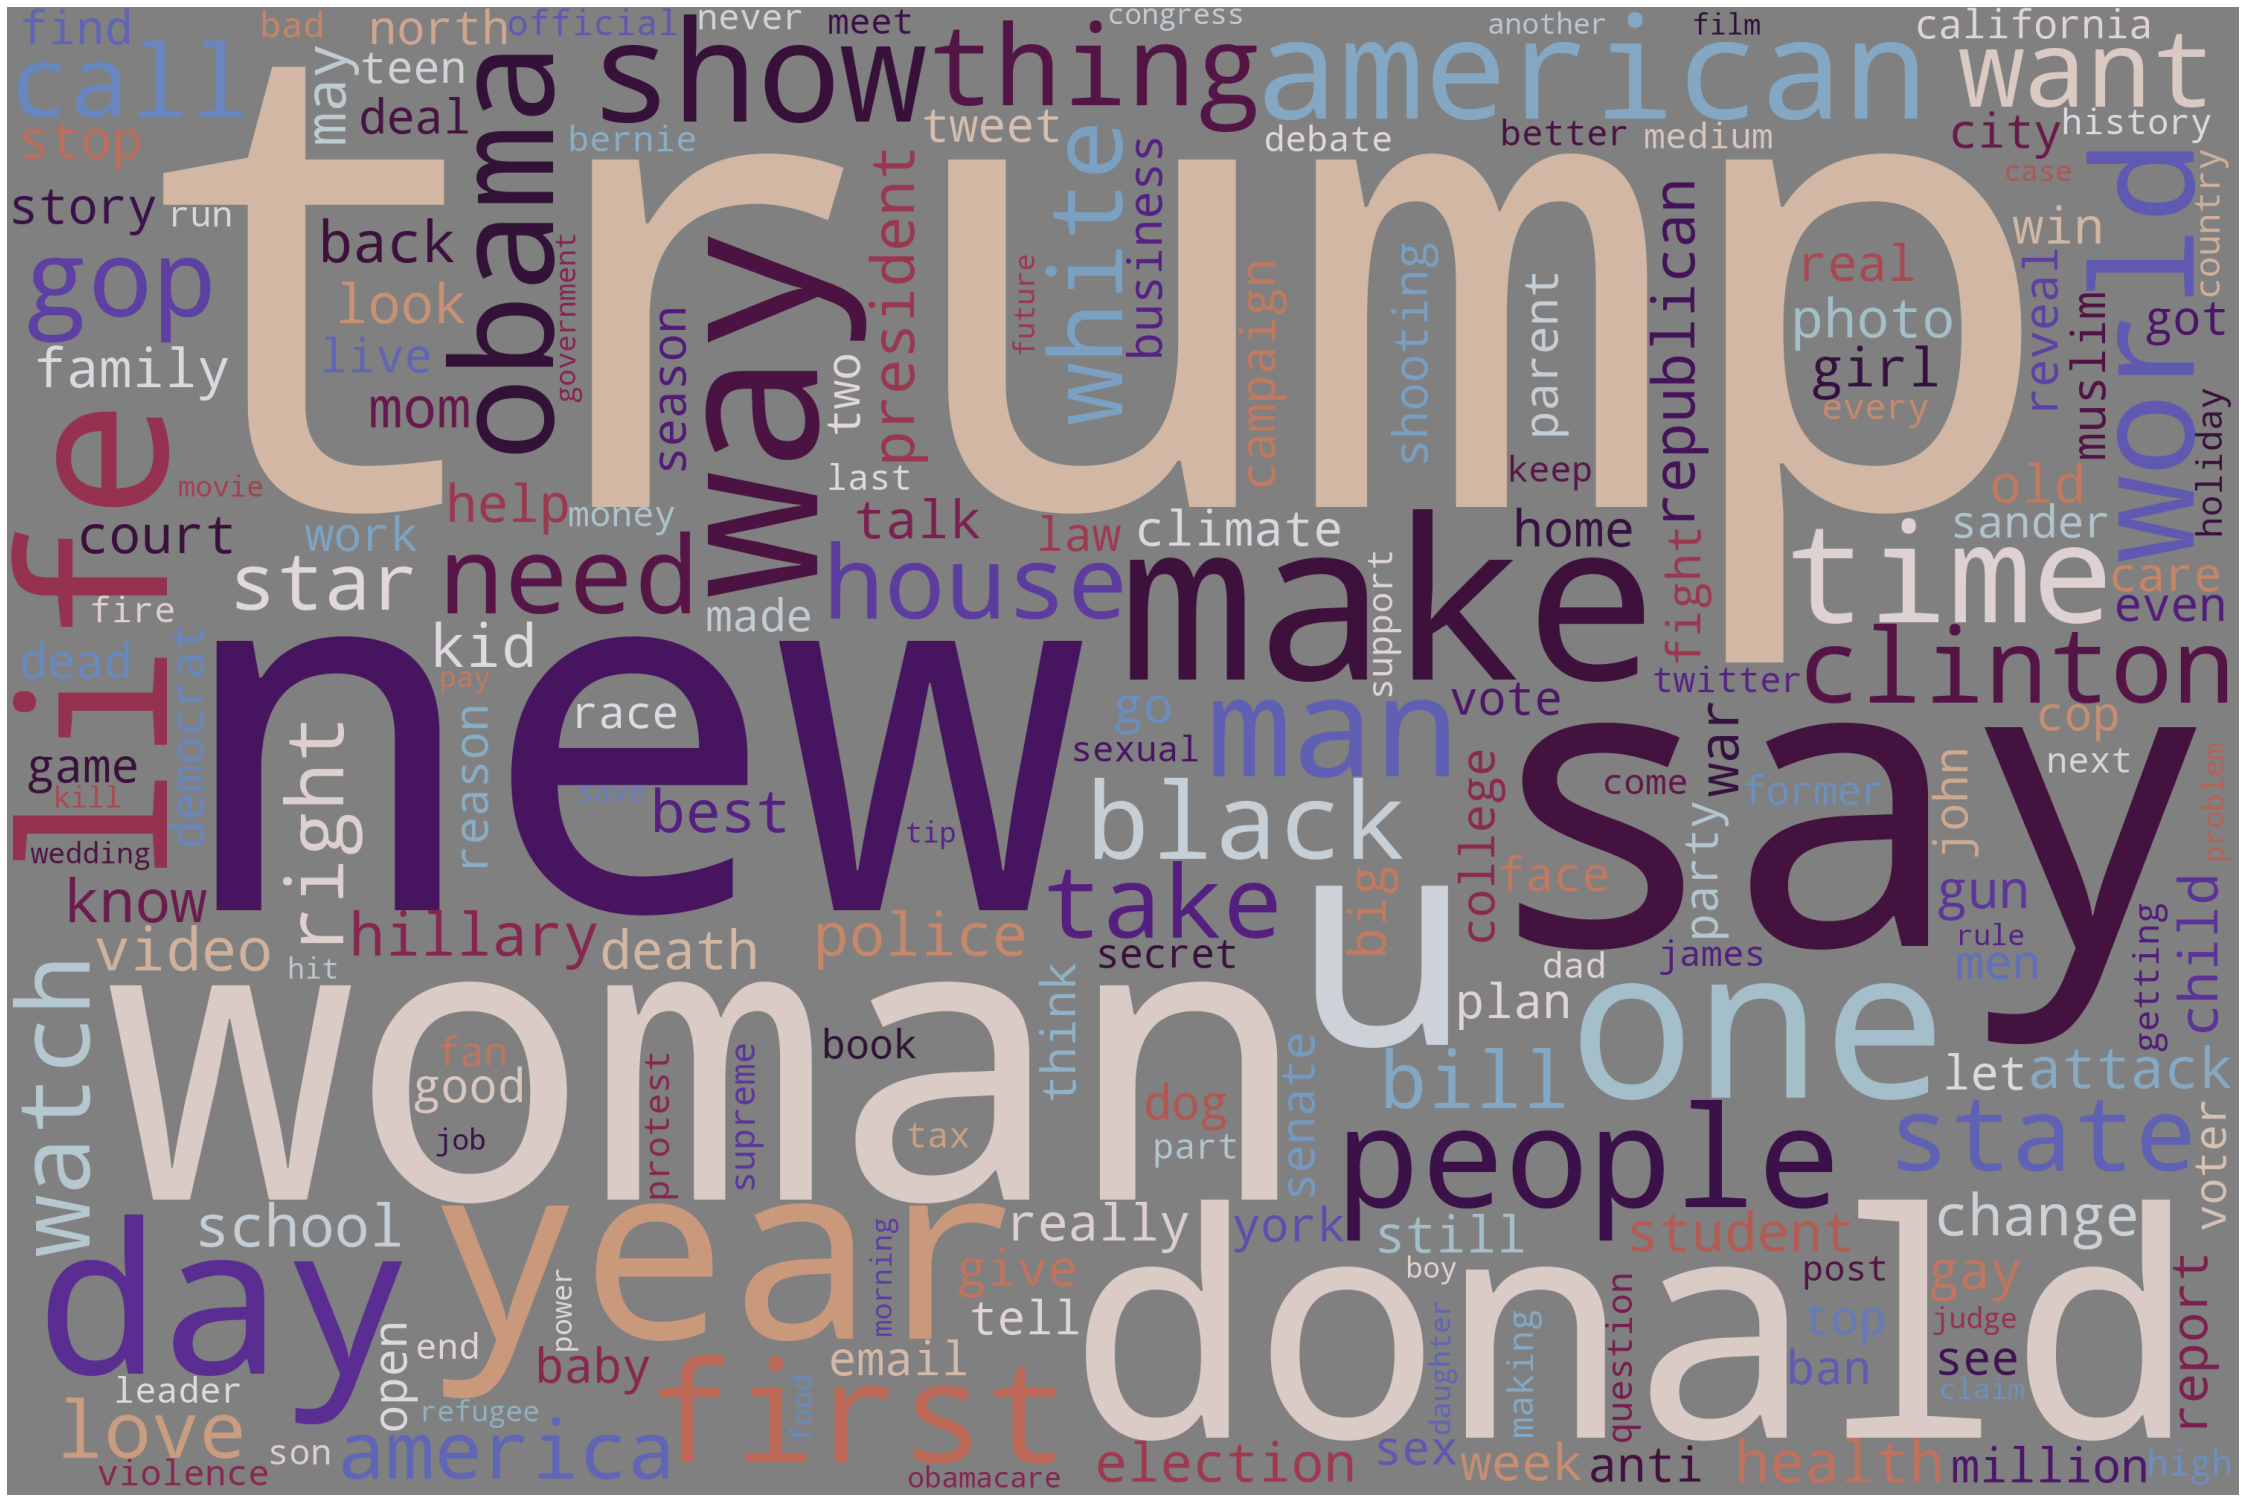

In [13]:
nonsarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])

nonsarcastic_cloud = WordCloud(width = 3000, height = 2000, random_state=7, background_color='grey', colormap='twilight', 
                      collocations=False, stopwords = STOPWORDS).generate(nonsarcastic_headlines)

plot_cloud(nonsarcastic_cloud)

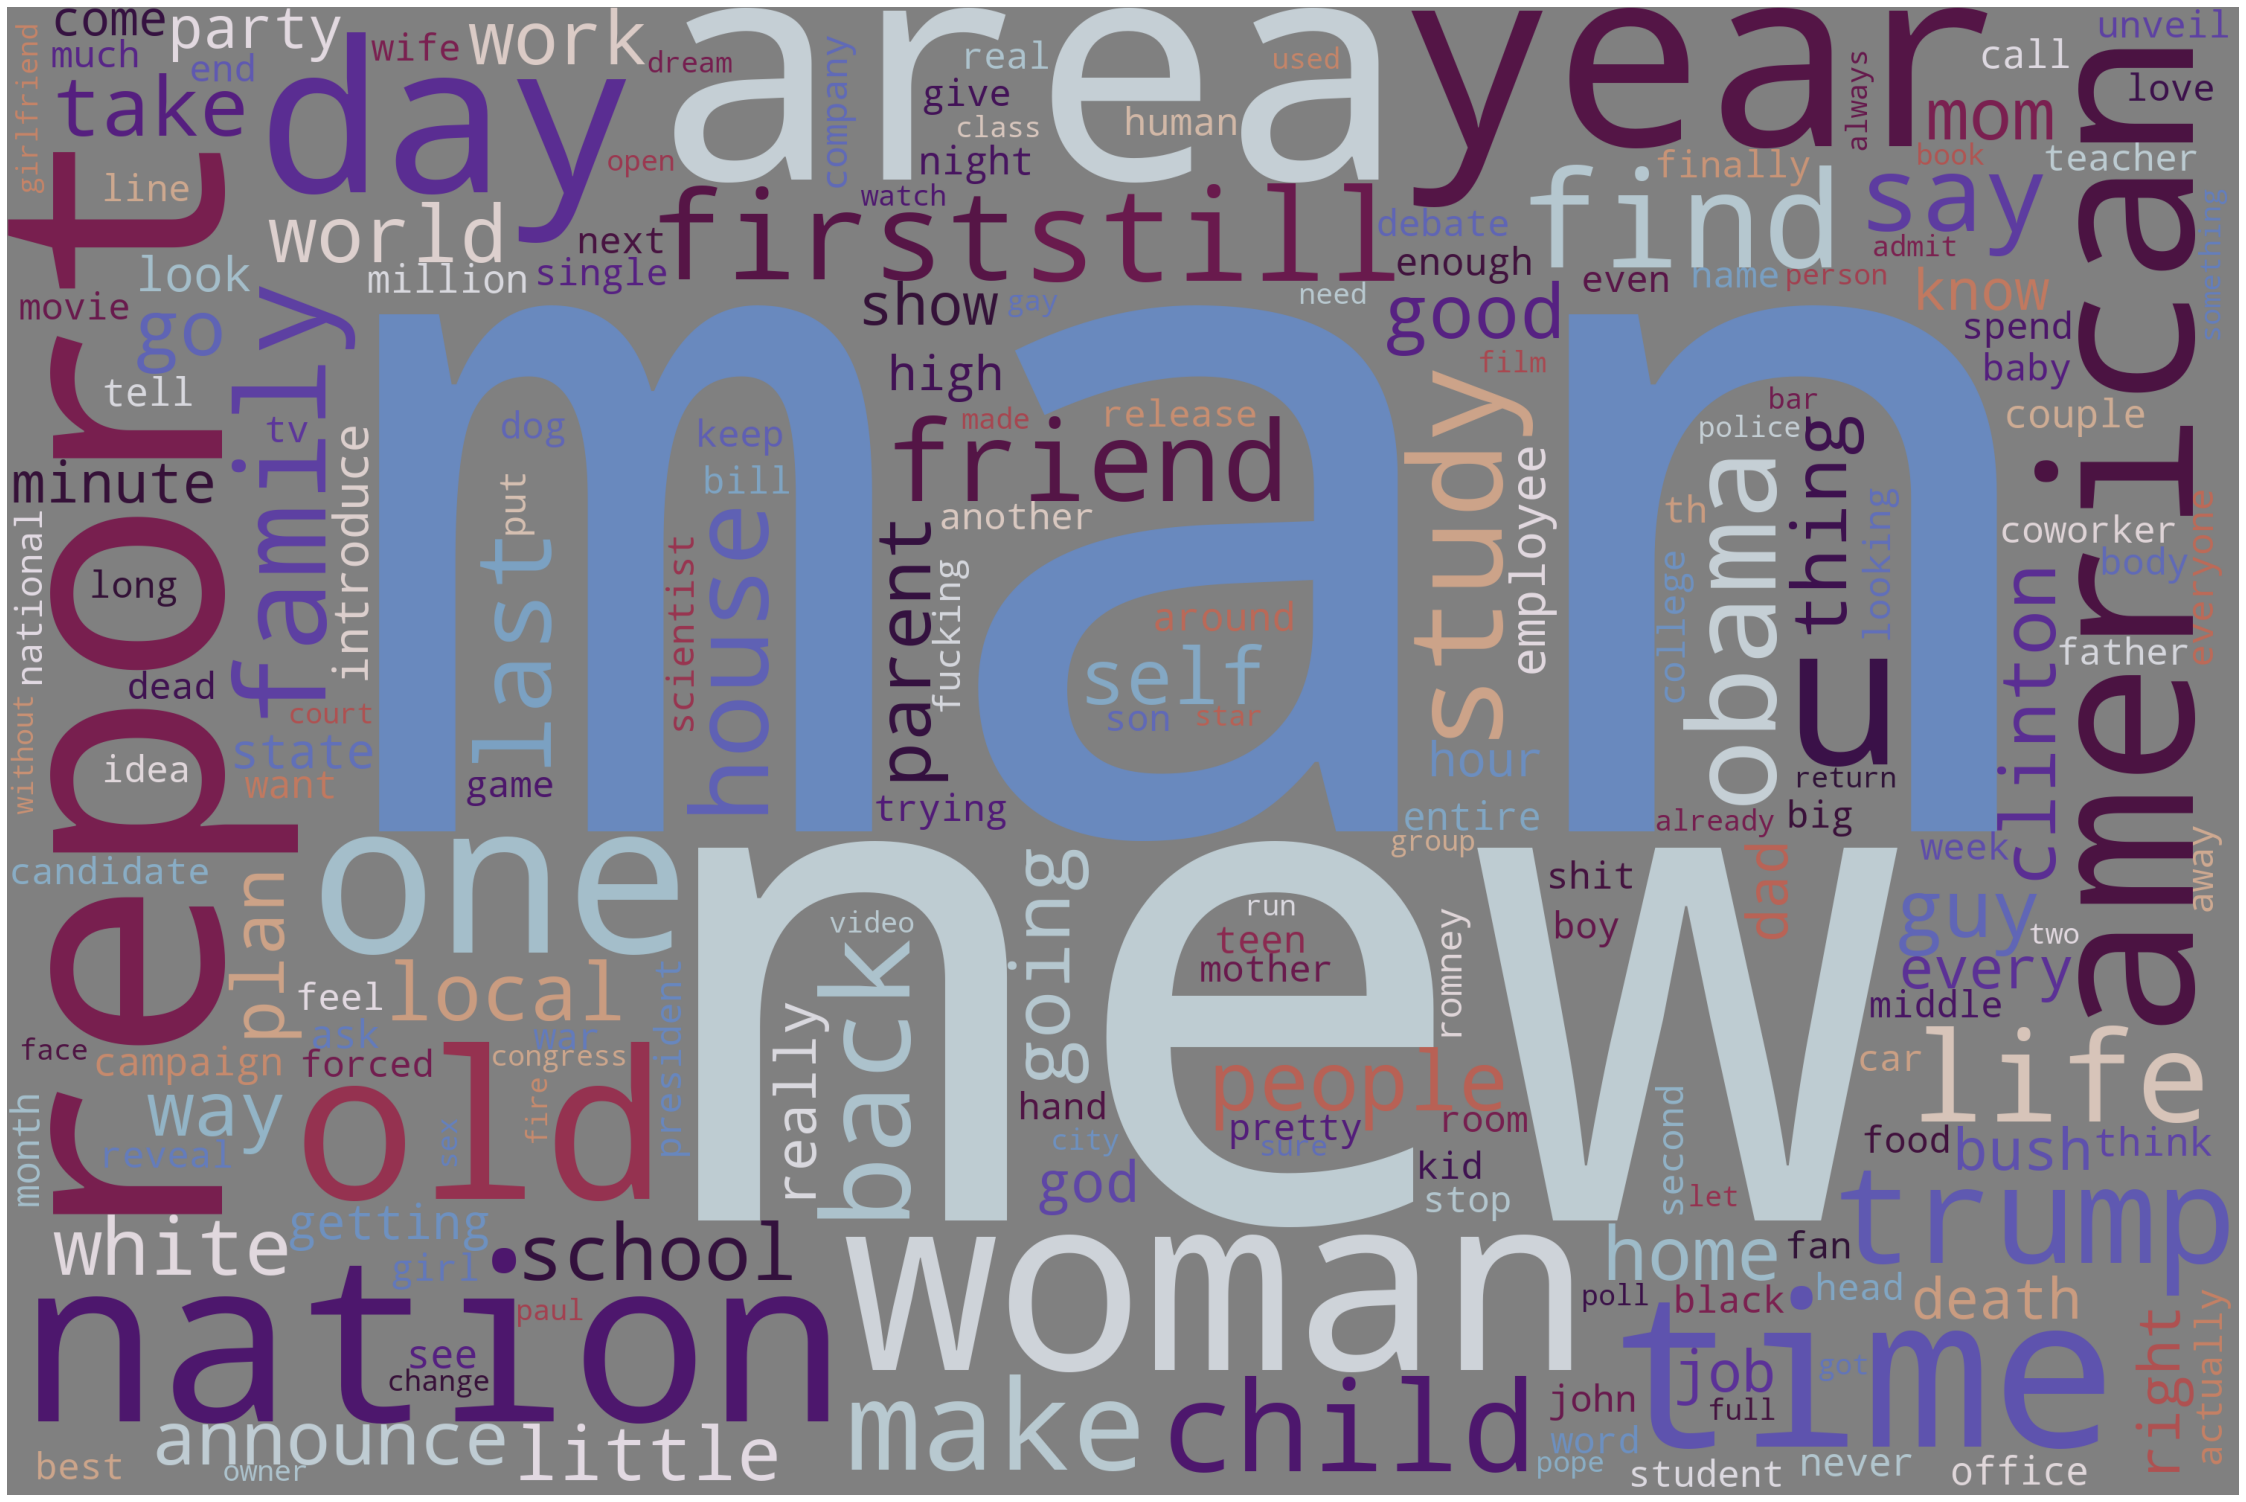

In [14]:
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])

sarcastic_cloud = WordCloud(width = 3000, height = 2000, random_state=7, background_color='grey', colormap='twilight', 
                      collocations=False, stopwords = STOPWORDS).generate(sarcastic_headlines)

plot_cloud(sarcastic_cloud)

## Train, Tune and test a model

In [15]:
# Setting parameters for the model
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

In [16]:
# Applying tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [17]:
# Defining X and y for the model
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 26709
Number of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  240  492 2699 1174  207   44 1767
 1944 3528]

Label of the first headline: 0


In [18]:
# Getting the vocabulary size
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 21731


In [19]:
# Get Glove word embeddings
glove_file = 'C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 11 - Sequential NLP\\glove.6B.zip'

In [20]:
# Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [21]:
# Get word embeddings using embedding file
Embedding_file = 'C:\\Users\\Rakesh Gowda S N\\Documents\Projects\\Project 11 - Sequential NLP\\glove.6B.200d.txt'

embeddings = {}
for o in open(Embedding_file, encoding="utf8"):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [22]:
# Creating a weight matrix
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

* Split the data into train, valid and test set
* Use Sequential model instance
* Add Embedding layer
* Bidirectional(LSTM) layer
* GlobalMaxPool1D layer
* Dense, dropout layers
* Add a final dense layer with sigmoid activation for binary classification

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 18696
Number of columns in training dataset: 30
Number of unique words in training dataset: 9853
------------------------------------------------------------ 
Number of rows in test dataset: 8013
Number of columns in test dataset: 30
Number of unique words in test dataset: 8301


In [24]:
opti = Adam(lr = 0.01)

model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), 
                    input_length = maxlen, trainable = False))

model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = opti, metrics = ['accuracy'])

# Adding callbacks
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)  
model_cp = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr=0.0005, verbose=1),

# logdir = 'log'; 
# tb = TensorBoard(logdir, histogram_freq = 1)

# callbacks = [mcp]
callbacks = [early_stop, model_cp, reduce_lr]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 200)           2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir log/

In [26]:
# tf.keras.utils.plot_model(model, show_shapes = True)

In [27]:
# Fitting model
# Setting batch_size = 100 and epoch = 2

batch_size = 100
epochs = 20

history = model.fit(x_train, y_train, epochs = epochs, 
              validation_split = 0.2, batch_size = batch_size, verbose = 1, callbacks = callbacks)

Epoch 1/20
150/150 [==============================] - 11s 54ms/step - loss: 0.6560 - accuracy: 0.6060 - val_loss: 0.4964 - val_accuracy: 0.7596

Epoch 00001: val_loss improved from inf to 0.49637, saving model to sarcasm_detector.h5
Epoch 2/20
150/150 [==============================] - 7s 45ms/step - loss: 0.4956 - accuracy: 0.7669 - val_loss: 0.4820 - val_accuracy: 0.7805

Epoch 00002: val_loss improved from 0.49637 to 0.48203, saving model to sarcasm_detector.h5
Epoch 3/20
150/150 [==============================] - 6s 41ms/step - loss: 0.4293 - accuracy: 0.8102 - val_loss: 0.4519 - val_accuracy: 0.7949

Epoch 00003: val_loss improved from 0.48203 to 0.45192, saving model to sarcasm_detector.h5
Epoch 4/20
150/150 [==============================] - 6s 42ms/step - loss: 0.3652 - accuracy: 0.8457 - val_loss: 0.4548 - val_accuracy: 0.7858

Epoch 00004: val_loss did not improve from 0.45192
Epoch 5/20
150/150 [==============================] - 6s 41ms/step - loss: 0.3308 - accuracy: 0.8624

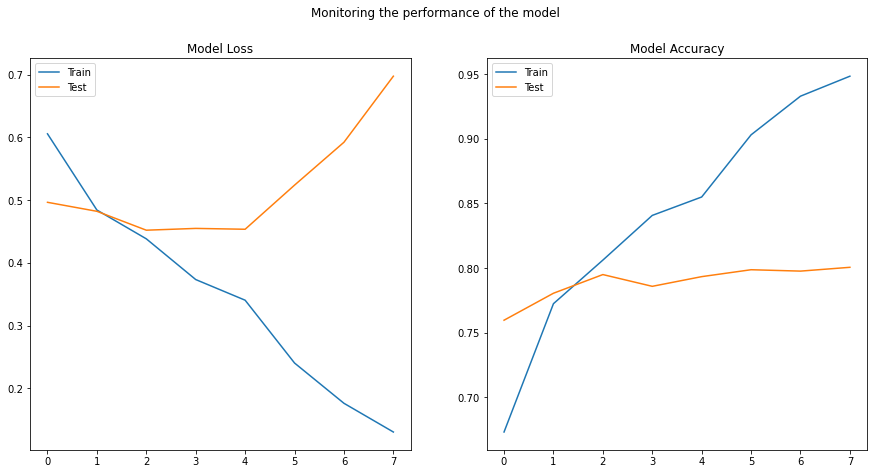

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(history.history['loss'], label = 'Train')
ax1.plot(history.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(history.history['accuracy'], label = 'Train')
ax2.plot(history.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

## Evaluate the model

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 81.0


In [30]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      4721
           1       0.76      0.79      0.77      3292

    accuracy                           0.81      8013
   macro avg       0.80      0.81      0.81      8013
weighted avg       0.81      0.81      0.81      8013



Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,3888,689
Sarcastic,833,2603


------------------------------------------------------------


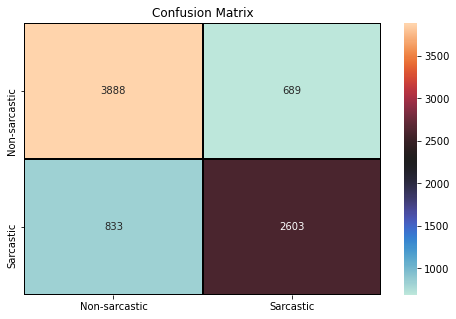

In [31]:
# print('--'*30);
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'icefire', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [32]:
# Calculate the metrics Accuracy, Precision, Recall and F1-Score
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"Accuracy": round(model_accuracy, 2),
                  "Precision": round(model_precision*100, 2),
                  "Recall": round(model_recall*100, 2),
                  "F1_score": round(model_f1*100,2)}
    return model_results

calculate_results(y_test,
                  y_pred)

{'Accuracy': 81.01, 'Precision': 80.95, 'Recall': 81.01, 'F1_score': 80.95}

Given the small dataset we have achieved decent results of all metrics which are around 81% using Bi-directional LSTM.